In [49]:
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

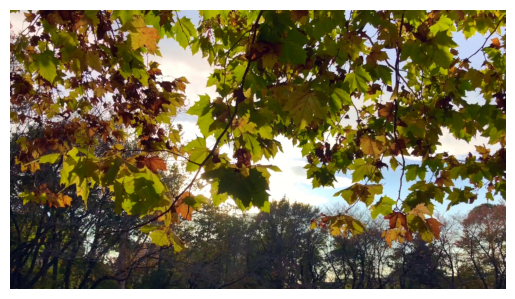

In [50]:
image = cv2.imread('frame_0000.jpg')
inmage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(inmage)
# Display the image using matplotlib
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.axis('off')  # Hide axes
plt.show()

In [51]:
# function which returns an object of class SuperPixel
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

In [57]:
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])
def initial_cluster_center(S, img, img_h, img_w, clusters):
    num_clusters = (img_h // S) * (img_w // S)
    for _ in range(num_clusters):
        h = np.random.randint(0, img_h-10)
        w = np.random.randint(0, img_w-10)
        clusters.append(make_superPixel(h, w, img))
    return clusters
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image)
    rgb_arr = (rgb_arr * 255).astype(np.uint8)
    io.imsave(name, rgb_arr)
    plt.imshow(rgb_arr)
    plt.axis('off')  # Hide axes
    plt.show()

def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])
    


def slic(labels):
    S, img, img_h, img_w, clusters, tag, dis, k, m = labels
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(10): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == 9 : # to print the output after 10 iterations
            name = 'out_m{m}_k{k}.png'.format(loop=i, m=m, k=k)
            avg_color_cluster(img,name, clusters)
    return clusters
# function to convert LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    rgb_arr = (rgb_arr * 255).astype(np.uint8)
    io.imsave(path, rgb_arr)

# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

def process_image(image_path, k=100, m=20):
    # read the input RGB image
    rgb = io.imread(image_path, plugin='matplotlib')
    print(rgb.shape)

    # input images are resized to (400 x 400) for processing
    img = resize(rgb, (400, 400), anti_aliasing=True)
    print(img.shape)

    # convert RGB to LAB
    img = color.rgb2lab(img)

    img_h = img.shape[0]  # Image Height
    img_w = img.shape[1]  # Image Width

    N = img_h * img_w  # Total number of pixels in the image
    S = int(math.sqrt(N / k))  # average size of each superpixel

    clusters = []
    tag = {}
    # initialize the distance between pixels and cluster center as infinity
    dis = np.full((img_h, img_w), np.inf)

    return (S, img, img_h, img_w, clusters, tag, dis, k, m)


/tmp/ipykernel_517899/1457044351.py:112: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


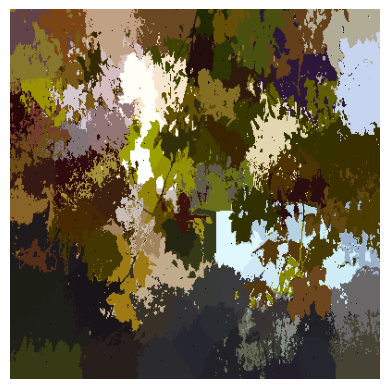

In [58]:

# Example usage
labelsdef = process_image("frame_0000.jpg")
cluster = slic(labelsdef)

/tmp/ipykernel_517899/1457044351.py:112: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


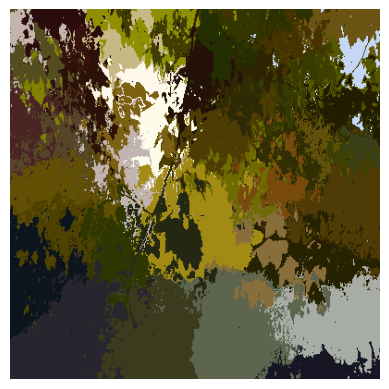

In [59]:

# Example usage
labels5010 = process_image("frame_0000.jpg", k=50, m=10)
cluster = slic(labels5010)

/tmp/ipykernel_517899/1457044351.py:112: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


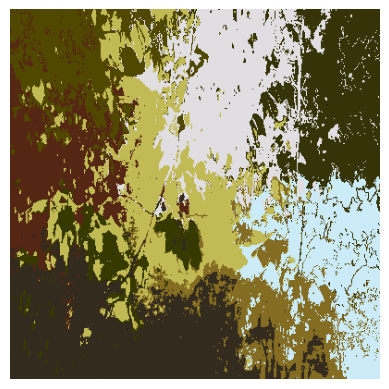

In [60]:

# Example usage
labels51015 = process_image("frame_0000.jpg", k=10, m=15)
cluster = slic(labels51015)

/tmp/ipykernel_517899/1457044351.py:112: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


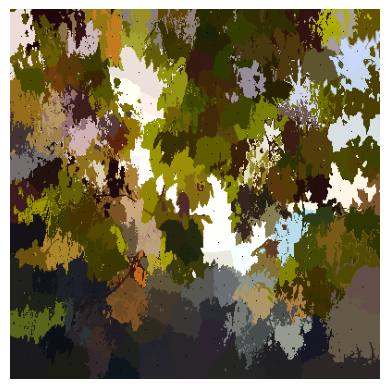

In [61]:

# Example usage
labelswut = process_image("frame_0000.jpg", k=200, m=50)
cluster = slic(labelswut)

In [38]:
# superpixels
for c in cluster:
    print("H {} : W {}, l {}, a {}, b {}".format(c.h,c.w,c.l,c.a,c.b))

# Segmenting the Video